In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Fraud.csv')

In [3]:
# Step 2: Data Preprocessing
# Check for missing values
assert data.isnull().sum().sum() == 0, "Ensure all features are numeric and there are no missing values."

In [4]:
# Separate features and target
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
target = 'isFraud'  # This is the target variable

X = data[features]
y = data[target]


In [5]:
# Handle constant columns and multicollinearity
numeric_data = X.select_dtypes(include=['float64', 'int64'])
numeric_data = numeric_data.loc[:, (numeric_data != numeric_data.iloc[0]).any()]  # Drop constant columns


In [6]:
# Calculate VIF to check for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(len(numeric_data.columns))]

In [7]:
# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Step 4: Identify columns with object data types
object_columns = X_train.select_dtypes(include='object').columns

In [9]:
# Step 5: Convert object columns to 'category' or apply one-hot encoding
for col in object_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [10]:
# Step 6: Set up the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

In [11]:
# Step 7: Initialize the XGBoost classifier with categorical support enabled
xgb_model = xgb.XGBClassifier(use_label_encoder=False, enable_categorical=True)

In [12]:
# Step 8: Set up the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [13]:
# Step 9: Fit RandomizedSearchCV with training data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 2, 3],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9]},
                   random_state=42, scoring='accuracy', verbose=2)

In [17]:
# Step 10: Evaluate model performance
best_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")
accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy*100}")

Best parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Test set accuracy: 99.97791790174489


In [18]:
# Step 11: Additional model performance metrics
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc*100}")
print(f"Precision: {precision*100}")
print(f"Recall: {recall*100}")
print(f"F1 Score: {f1*100}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ROC AUC: 93.11500211028947
Precision: 96.01374570446735
Recall: 86.23456790123457
F1 Score: 90.86178861788619

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.86      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.93      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



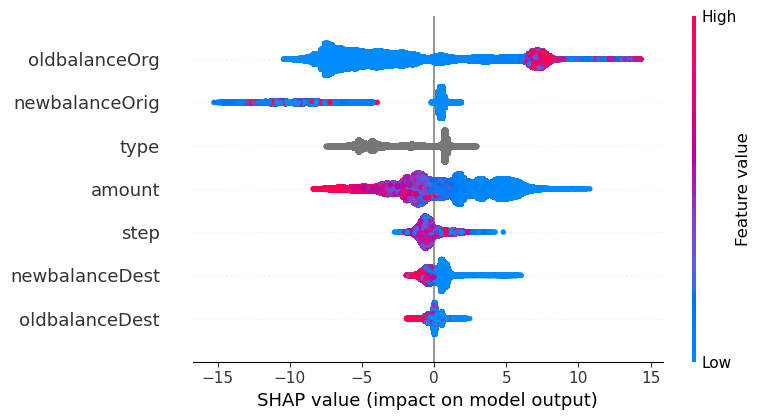

In [16]:
# Optional: Plot SHAP values for feature importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)